# Time-Series Models using Sktime and Statsmodels 

**Summary**

In this notebook we will forecast precipitation. Before we make any models we will check for any seasonality in our data and determine if it's stationary or not. We decided that setting our time frame to 'months' will yield the best results because our baseline model's MSE performed 0.02 better than the 'weekly' time frame. 

Baseline Model 
- We will use a NaiveForecaster as our baseline model. The mean of the last seasonal window is a brute-force method to establish a baseline.
  
Holt-Winters Model
- Using autoEST

SARIMA Model
- Using autoARIMA

Ensemble Forecaster Model
- Using SARIMA and Holt-Winters models 

Metrics = Root-Mean-Squared-Error 
- Finding our mean error in the units of our target variable 'precipitation' will help us understand how off our model is. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
import pmdarima as pmd
from sktime.forecasting.compose import EnsembleForecaster

In [3]:
df = pd.read_csv('../data/fresno_eda.csv', index_col='datetime', parse_dates=True)
df = pd.DataFrame(df['precip'])

In [4]:
df.shape

(10959, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 1992-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  10959 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


In [6]:
df_month = df.resample('M').mean()

In [7]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1992-01-31 to 2022-01-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [8]:
df_month.isnull().sum()

precip    0
dtype: int64

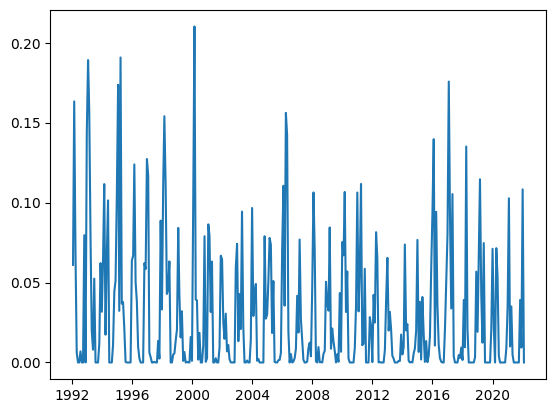

In [9]:
plt.plot(df_month)

- Visually we can see no signs of trend. 
- We can see signs of additive seasonality because the peaks remain a relative magnitude 

In [10]:
# Code written by Joseph Nelson.
# Improved by Hovanes Gasparian
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

- Because our df_month timeframe is below the 0.01 p_value standard we pass the stationarity test. 

In [11]:
interpret_dftest(adfuller(df_month))

Test Statistic    -3.848855
p-value            0.002445
Lag Used          12.000000
dtype: float64

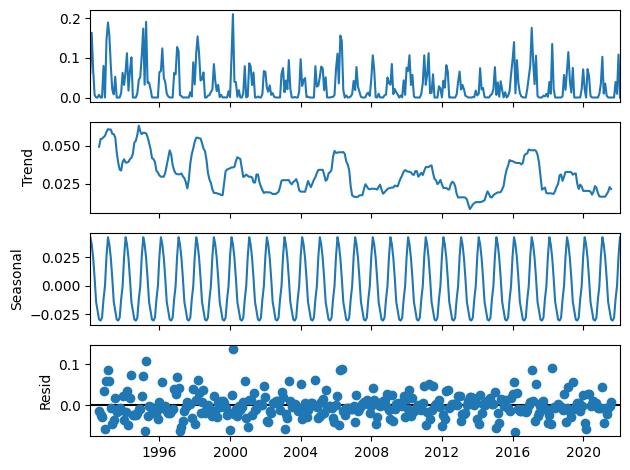

In [12]:
decomp = seasonal_decompose(df_month)
decomp.plot();

#### Seasonal Decompose 
- We see no clear trend in our data 
- Our seasonality seems to be additive and consistent with actual weather seasons. We will establish our seasonality in months (12) for our models.  


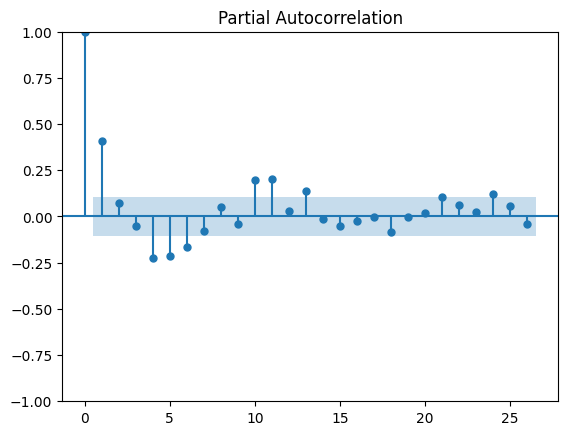

In [13]:
plot_pacf(df_month);
plt.savefig('../images/pacf.jpg')

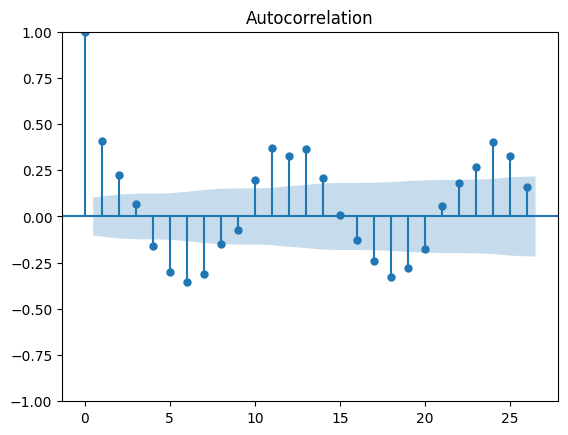

In [14]:
plot_acf(df_month);
plt.savefig('../images/acf.jpg')

#### Partial and Regular Autocorrelation
- We have clear seasonality because there are evident recurring peaks in the lags. Our autocorrelation also proves we have no trend because the first few initial nodes have dispersing correlations. 


In [15]:
train = df_month.loc['2005-09-01':'2021-09-01']

In [16]:
test = df_month.loc['2021-09-02':]

In [17]:
train.shape, test.shape

((192, 1), (5, 1))

Text(0, 0.5, 'precip')

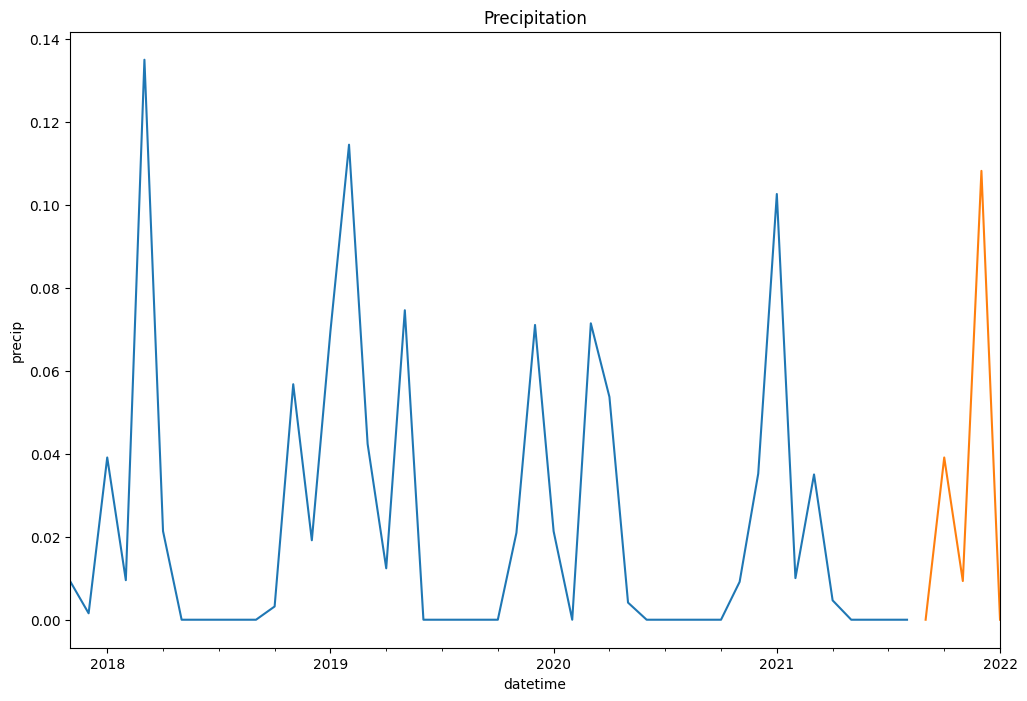

In [18]:
train['precip'].loc['2017-11-01':].plot()
test['precip'].plot(figsize = (12, 8), title = 'Precipitation');
plt.ylabel('precip')

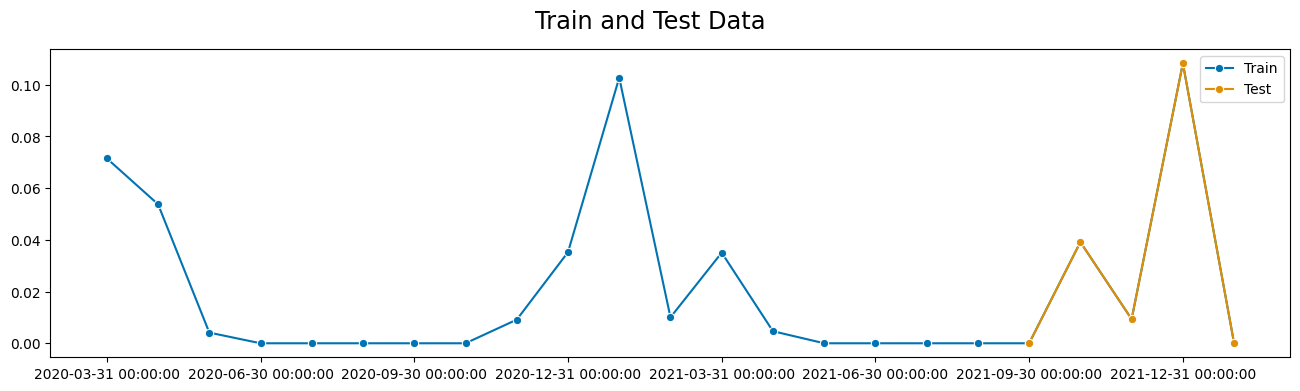

In [19]:
plot_series(df_month.loc['2020-03-02':], test, labels = ['Train', 'Test'], title = 'Train and Test Data');
plt.savefig('../images/train_test.jpg')

### Baseline Model 

This NaiveForecast model will take the mean of the last seasonal window as our baseline predictions. All other models, including RNN, will base their success off of having a lower RMSE than our baseline model.  

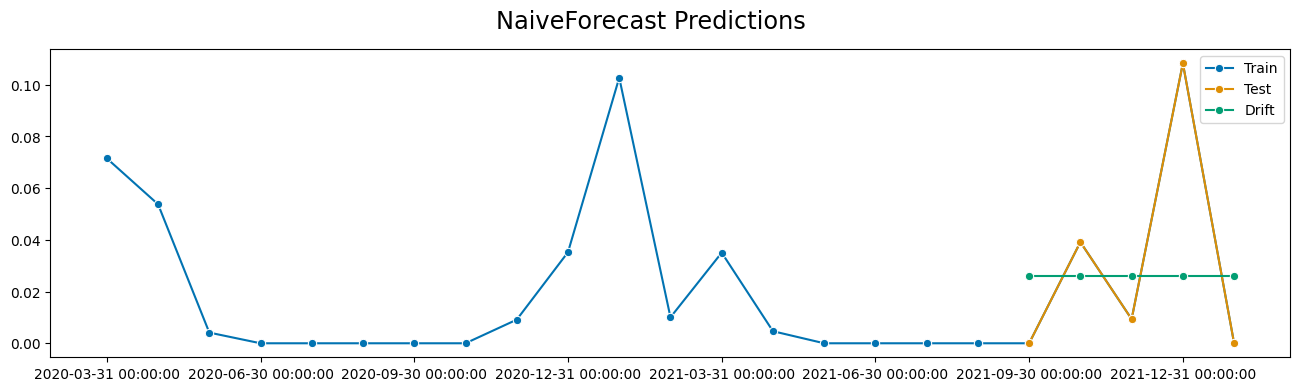

In [20]:

baseline_drift = NaiveForecaster(strategy = 'mean')

baseline_drift.fit(train)

baseline_drift_preds = baseline_drift.predict(test.index)

plot_series(df_month.loc['2020-03-02':], test, baseline_drift_preds, labels = ['Train', 'Test', 'Drift'], title = 'NaiveForecast Predictions')
plt.savefig('../images/naive.jpg')

In [21]:
mean_squared_error(test, baseline_drift_preds, squared=False)

0.04137363747374292

**Baseline RMSE Score:**
0.0414

---

## Holt-Winters AutoETS Model


In [22]:
hw_model = AutoETS(sp = 12, seasonal='add')

hw_model.fit(train)

AutoETS(seasonal='add', sp=12)

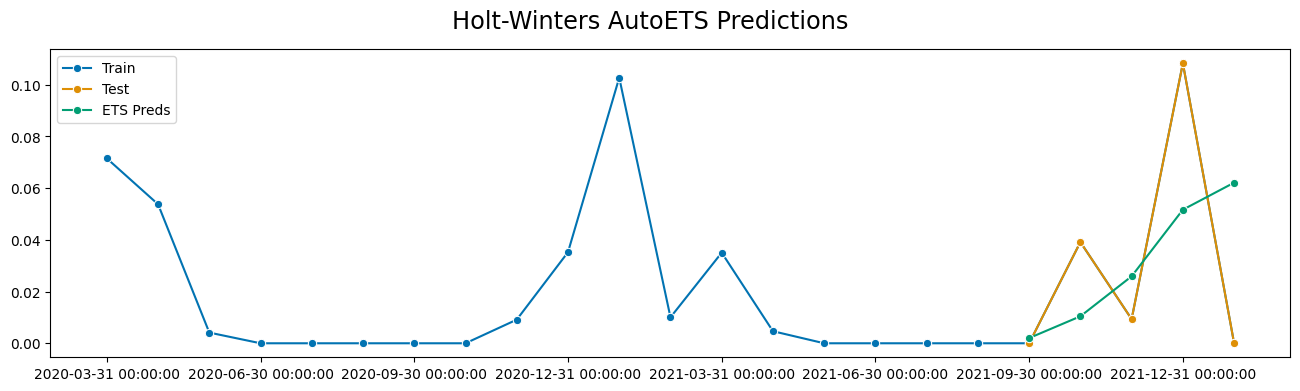

In [23]:
hw_preds = hw_model.predict(test.index)
plot_series(df_month.loc['2020-03-02':], test, hw_preds, labels = ['Train', 'Test', 'ETS Preds'], title = 'Holt-Winters AutoETS Predictions');
plt.savefig('../images/hw.jpg')

In [24]:
mean_squared_error(test, hw_preds, squared=False)

0.04040582465609773

## Conclusion (HW-Model)
**Baseline RMSE Score:**
0.0414

**HW_EST_Model RMSE Score:**
0.0404

We can see that our HW_EST model is only performing marginally better than our baseline. 
We will proceed to test other models to find a better performance. 

---


# SARIMA Model 

We are choosing a SARIMA model because it takes seasonality into consideration and our data contains seasonality.
 

In [25]:
sarima_model = AutoARIMA(sp = 12, trace = True, suppress_warnings=True)

In [26]:
sarima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-773.789, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-724.159, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-753.232, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-748.399, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-645.828, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-785.286, Time=0.48 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-786.709, Time=0.16 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-775.723, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-749.574, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-748.899, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=-749.603, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=-761.132, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-750.677, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=-755.372, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0

AutoARIMA(sp=12, suppress_warnings=True, trace=True)

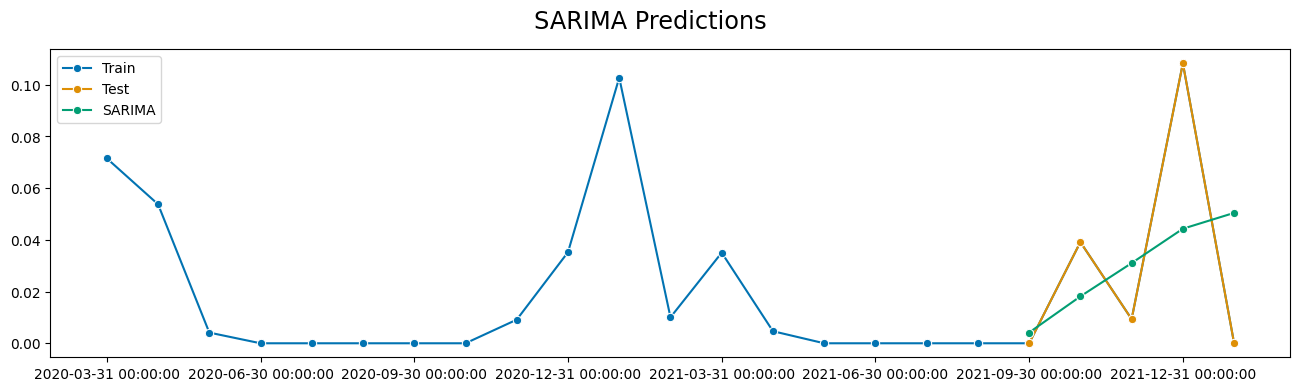

In [27]:

sarima_preds = sarima_model.predict(test.index)
plot_series(df_month.loc['2020-03-02':], test, sarima_preds,
           labels = ['Train', 'Test', 'SARIMA'], title = 'SARIMA Predictions')
plt.savefig('../images/sarima.jpg')

In [28]:
mean_squared_error(test, sarima_preds, squared=False)

0.03888894984862489

## Conclusion (SARIMA model)
**Baseline RMSE Score:**
0.0414

**HW_EST_Model RMSE Score:**
0.0404

**SARIMA_Model RMSE Score:**
0.0389

So far our SARIMA model is showing the least average error. Although our improvements in our predictions are minimal, the average measure of precipitation per month is fractions of an inch. This means that any development will also be within fractions of an inch. 

---

## Ensemble Forecaster Model

We will want to use an ensemble forecaster because it will aggregate the predictions of our better performing models. We will see if this improves our predictions. 

In [29]:
forecaster = EnsembleForecaster([
    ('sarima', sarima_model),
    ('hw', hw_model)
], n_jobs = -1)

forecaster.fit(train)

ensemble_preds = forecaster.predict(test.index)

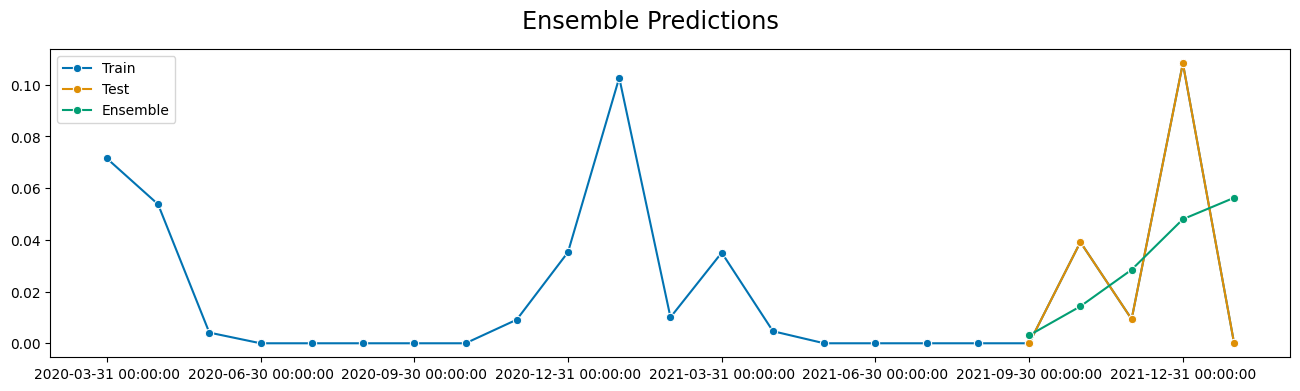

In [30]:
plot_series(df_month.loc['2020-03-02':], test, ensemble_preds, labels = ['Train', 'Test', 'Ensemble'], title= 'Ensemble Predictions')
plt.savefig('../images/ensemble.jpg')

In [31]:
mean_squared_error(test, ensemble_preds,squared=False)

0.03947727232398758

# Conclusions (EnsembleForecast Model)

**Baseline RMSE Score:**
0.0414

**HW_EST_Model RMSE Score:**
0.0404

**SARIMA_Model RMSE Score:**
0.0389

**Ensemble_Forecast_Model RMSE Score:**
0.0395

We can see our Ensemble Forecast performed in between our HW and SARIMA models. 
